# Training a CNN with Keras on the CIFAR 10 dataset

Use this notebook to train a Convolutional Neural Network on the CIFAR-10 dataset


Start with importing the necessary packages

In [12]:
import os
import time

import matplotlib.pyplot as plt
from keras import backend as K
from keras import initializers
from keras import layers as KL
from keras import models
from keras import optimizers
from keras import regularizers
from keras import callbacks
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from helperutils import results, MyDataLoader
# from helperutils.DataLoader import MyDataLoader

In [34]:
# Set input arguments
debug = False
verbose = 1
continue_training = True
augment_data = True

In [18]:
# image details
height = 32
width = 32
depth = 3

inputShape = (height, width, depth)
chanDim= -1
# if we are using "channels first", update the input shape
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1


# Set nr of classes we need to classify
classes = 10

# Load data
Using our custom `DataLoader`-class

In [19]:
print("[INFO] loading CIFAR-10 data...")
(trainX, trainY), (testX, testY), labelNames = MyDataLoader().load_dataset()

# Debug
if debug:
    print("[DEBUG] Only using 100 images")
    trainX = trainX[:100]
    trainY = trainY[:100]
    testX = testX[:100]
    testY = testY[:100]

print("Training set size X: ", trainX.shape)
print("Training set size Y: ", trainY.shape)
print("Test set size X: ", testX.shape)
print("Test set size Y: ", testY.shape)

[INFO] loading CIFAR-10 data...
Loading training images
[INFO] processed 5000
[INFO] processed 10000
[INFO] processed 15000
[INFO] processed 20000
[INFO] processed 25000
[INFO] processed 30000
[INFO] processed 35000
[INFO] processed 40000
[INFO] processed 45000
[INFO] processed 50000
Loading test images
[INFO] processed 5000
[INFO] processed 10000
Training set size X:  (50000, 32, 32, 3)
Training set size Y:  (50000, 10)
Test set size X:  (10000, 32, 32, 3)
Test set size Y:  (10000, 10)


## Preview a training item

deer


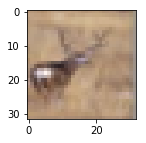

In [20]:
plt.figure(figsize=(2,2))
plt.imshow(trainX[0])
print(labelNames[np.argmax(trainY[0])])

### Define model

This is where you can define your own model


In [43]:
# TODO: clean up


# define a first CNN with Keras
model = models.Sequential()


print("start")

kernels= [(3,3),(5,5),(7,7)]
filters = [64,32,16]
pool_size = (2,2)


# Start with 3 parallel Conv -> Pool -> BN and 1 Conv -> Act
branches = []
for kernel_size, filter_size in zip(kernels, filters):
    branch_input = KL.Input(shape=inputShape)
    branch = KL.Conv2D(filter_size, kernel_size=kernel_size, padding="same", input_shape=inputShape)(branch_input)
    branch = KL.MaxPooling2D(pool_size=pool_size)(branch)
    out = KL.BatchNormalization(axis=chanDim)(branch)

    branch = KL.Conv2D(filter_size, kernel_size=kernel_size, padding="same")(branch)
    branch = KL.MaxPooling2D(pool_size=pool_size)(branch)
    out = KL.BatchNormalization(axis=chanDim)(branch)
    
    branch_model  = models.Model(branch_input, out)
    print(branch_model.summary())
    branches.append(branch_model)

branch_input = KL.Input(shape=inputShape)
branch = KL.Conv2D(16,(17,17), padding="valid", input_shape=inputShape)(branch_input)
out = KL.Conv2D(16,(9,9), padding="valid", input_shape=inputShape)(branch)

branch_model = models.Model(branch_input, out)
print(branch_model.summary())
branches.append(branch_model)

start
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_53 (Batc (None, 8, 8, 64)          256       
Total params: 38,976
Trainable params: 38,848
Non-trainable params: 128
________________________________________________________________

In [44]:
inp=[]
x=[]
input_layer = KL.Input(shape=inputShape)
for branch in branches:
    inn = KL.Input(shape=inputShape)
    print('adding parallel layer: ', branch)
    x.append(branch(input_layer))
    inp.append(inn)

print(branches)
print(x)
print( "------")
merged = KL.concatenate(x, axis=chanDim)
print('--- out ---')
print(merged)

# print("here")
# x = Flatten()(merged)
# print(x)
# out = Dense(classes, activation="softmax")(x)


print("in:", inp)
print("out:", out)
# model = Model(inp, out)
# out = Conv2D(128,(3,3), padding="same")(out)
# conv_model = Model(inputs=input_layer, outputs=out)


# model.add(conv_model)
# print('--- done ---')
    
x = KL.Conv2D(64, (5, 5), padding="same")(merged)
x = KL.MaxPooling2D(pool_size=(2,2))(x)
x = KL.Dropout(rate=0.5)(x)

x = KL.Conv2D(64, (5, 5), padding="same")(x)
x = KL.MaxPooling2D(pool_size=(2,2))(x)
x = KL.BatchNormalization(axis=chanDim)(x)

x = KL.Conv2D(128, (5, 5), padding="same")(merged)
x = KL.MaxPooling2D(pool_size=(2,2))(x)
x = KL.Dropout(rate=0.5)(x)

x = KL.Conv2D(256, (5, 5), padding="same")(x)
x = KL.MaxPooling2D(pool_size=(2,2))(x)
x = KL.BatchNormalization(axis=chanDim)(x)


# softmax classifier
x = KL.Flatten()(x)
x = KL.Dense(64, activation="relu")(x)
x = KL.Dense(32, activation="relu")(x)
out = KL.Dense(10, activation="softmax")(x)

model = models.Model(input_layer, out)


model.summary()

adding parallel layer:  <keras.engine.training.Model object at 0x7febc4054b70>
adding parallel layer:  <keras.engine.training.Model object at 0x7febb7e6e5f8>
adding parallel layer:  <keras.engine.training.Model object at 0x7febb7b4bf98>
adding parallel layer:  <keras.engine.training.Model object at 0x7febb7ab5400>
[<keras.engine.training.Model object at 0x7febc4054b70>, <keras.engine.training.Model object at 0x7febb7e6e5f8>, <keras.engine.training.Model object at 0x7febb7b4bf98>, <keras.engine.training.Model object at 0x7febb7ab5400>]
[<tf.Tensor 'model_33/batch_normalization_53/cond/Merge:0' shape=(?, 8, 8, 64) dtype=float32>, <tf.Tensor 'model_34/batch_normalization_55/cond/Merge:0' shape=(?, 8, 8, 32) dtype=float32>, <tf.Tensor 'model_35/batch_normalization_57/cond/Merge:0' shape=(?, 8, 8, 16) dtype=float32>, <tf.Tensor 'model_36/conv2d_74/BiasAdd:0' shape=(?, 8, 8, 16) dtype=float32>]
------
--- out ---
Tensor("concatenate_6/concat:0", shape=(?, 8, 8, 128), dtype=float32)
in: [<tf.

## Setting hyperparameters

In [49]:
# Setting hyperparameters
epochs = 10
learning_rate = 0.0001
decay = 0
momentum = 1
batch_size= 32

# optimizer
optimizer = optimizers.Adam(learning_rate)

name = 'DeepWideNet-CMD2x' 

result = results.Results(name)

## Checking if we need/can continue

Based on a property set in the top we will (dis)allow for continuation (property named `continue_training`). 

If that's there, the value will be used as filepath

In [50]:
print("[INFO] Checking if there's a set of weights that we can use")



filepath = '{}/{}-best.hdf5'.format(result.model_folder, name) 
# If exists a best model, load its weights!
if continue_training is True and os.path.isfile(filepath):
    print ("Resumed model's weights from {}".format(filepath))
    # load weights
    model.load_weights(filepath)
else:
    print("Nope, starting from scratch")

[INFO] Checking if there's a set of weights that we can use
Nope, starting from scratch


# Augment training data


In [51]:
data_generator = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

data_generator.fit(trainX)


### Training

In [53]:
tic = time.time()
print("[INFO] training network...")

# train the model using SGD
model.compile(loss="categorical_crossentropy", optimizer=optimizer,
                metrics=["accuracy"])

# Keep only a single checkpoint, the best over test accuracy.
checkpoint = callbacks.ModelCheckpoint(filepath,
                            monitor='val_acc',
                            verbose=1,
                            save_best_only=True,
                            mode='max')


if augment_data:
    print("[INFO] With augmented training data")
    # fits the model on batches with real-time data augmentation:
    training_data = data_generator.flow(trainX, trainY, batch_size=batch_size)
    H = model.fit_generator(training_data,
                        validation_data=(testX, testY),
                        steps_per_epoch=len(trainX) / batch_size,
                        epochs=epochs,
                        verbose=verbose,
                        callbacks=[checkpoint])
else:
    H = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=batch_size, epochs=epochs, verbose=verbose, callbacks=[checkpoint])
    
# The datagen generates batches of 32 training images / labels per step
# steps per epoch is used to determine when an epoch is done (number of step-batches that need to be 
# generated before an epoch is complete)
# https://keras.io/models/model/#fit_generator

print('Time taken to train {} epochs: {}'.format(epochs,time.time() - tic))

[INFO] training network...
[INFO] With augmented training data
Epoch 1/10
1563/1562 [==============================] - 39s 25ms/step - loss: 1.5808 - acc: 0.4269 - val_loss: 2.6670 - val_acc: 0.2227

Epoch 00001: val_acc improved from -inf to 0.22270, saving model to ./output/models/DeepWideNet-CMD2x-best.hdf5
Epoch 2/10
1563/1562 [==============================] - 37s 24ms/step - loss: 1.3833 - acc: 0.5042 - val_loss: 3.0655 - val_acc: 0.1483

Epoch 00002: val_acc did not improve from 0.22270
Epoch 3/10
1563/1562 [==============================] - 37s 24ms/step - loss: 1.2909 - acc: 0.5409 - val_loss: 2.6399 - val_acc: 0.2761

Epoch 00003: val_acc improved from 0.22270 to 0.27610, saving model to ./output/models/DeepWideNet-CMD2x-best.hdf5
Epoch 4/10
1563/1562 [==============================] - 38s 24ms/step - loss: 1.2114 - acc: 0.5672 - val_loss: 2.6142 - val_acc: 0.2523

Epoch 00004: val_acc did not improve from 0.27610
Epoch 5/10
1563/1562 [==============================] - 38s 24

## Evaluating the model

[INFO] Plotting 10 epochs


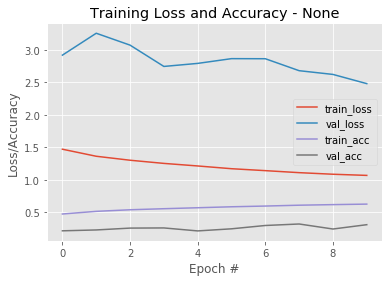

[INFO] evaluating network...
Result for DeepWideNet-2019-02-27T13:58
              precision    recall  f1-score   support

    airplane       0.74      0.27      0.40      1000
  automobile       1.00      0.01      0.02      1000
        bird       0.25      0.73      0.37      1000
         cat       0.47      0.05      0.08      1000
        deer       0.20      0.60      0.31      1000
         dog       1.00      0.01      0.01      1000
        frog       0.56      0.48      0.52      1000
       horse       1.00      0.00      0.01      1000
        ship       0.33      0.91      0.48      1000
       truck       1.00      0.00      0.00      1000

   micro avg       0.31      0.31      0.31     10000
   macro avg       0.66      0.31      0.22     10000
weighted avg       0.66      0.31      0.22     10000



In [41]:
# Showing training results
plot = result.get_performance_plot(H)
plot.show()



# evaluate the network
print("[INFO] evaluating network...")
result.evaluate(model, testX,testY, label_names= labelNames)


the results are stored in the `output` folder